In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [3]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    ParametersContainer,
    FormFactorModel,
    FormFactorVacancy,
    create_compound,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)
from rxrmask.optimization import (
    RXRModel,
)

In [4]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False)

la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)
x1_atom = Atom(
    Z=0,
    name="X1",
    ff=c_ff,
)
x2_atom = Atom(
    Z=0,
    name="X2",
    ff=c_ff,
)

In [9]:
parameters_container = ParametersContainer()

comp_SrTiO3 = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=0.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
comp_LaMnO3 = create_compound(
    parameters_container=parameters_container,
    name="LaMnO3",
    formula="La:1,Mn:1,O:3",
    thickness=10.0,
    density=6.52,
    atoms=[la_atom, mn_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
comp_CCO = create_compound(
    parameters_container=parameters_container,
    name="CO2",
    formula="X1:1,X2:1,O:2",
    thickness=10.0,
    density=5.0,
    atoms=[x1_atom, x2_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)

struc = Structure(name=f"Test Structure", n_compounds=3, params_container=parameters_container)
struc.add_compound(0, comp_SrTiO3)
struc.add_compound(1, comp_LaMnO3)
struc.add_compound(2, comp_CCO)
struc.validate_compounds()


comp_CCO.compound_details[0].thickness.set(15.0)
comp_CCO.compound_details[0].molar_density.set(0.0)
comp_CCO.compound_details[0].roughness.set(0.0)

comp_CCO.compound_details[1].thickness.set(9.0)
comp_CCO.compound_details[1].molar_density.set(0.075)
comp_CCO.compound_details[1].roughness.set(4.0)

comp_CCO.compound_details[2].thickness.set(6.0)
comp_CCO.compound_details[2].molar_density.set(0.055)
comp_CCO.compound_details[2].roughness.set(4.0)


struc.create_layers(step=0.1)

model = RXRModel(structure=struc, parameters_container=parameters_container)

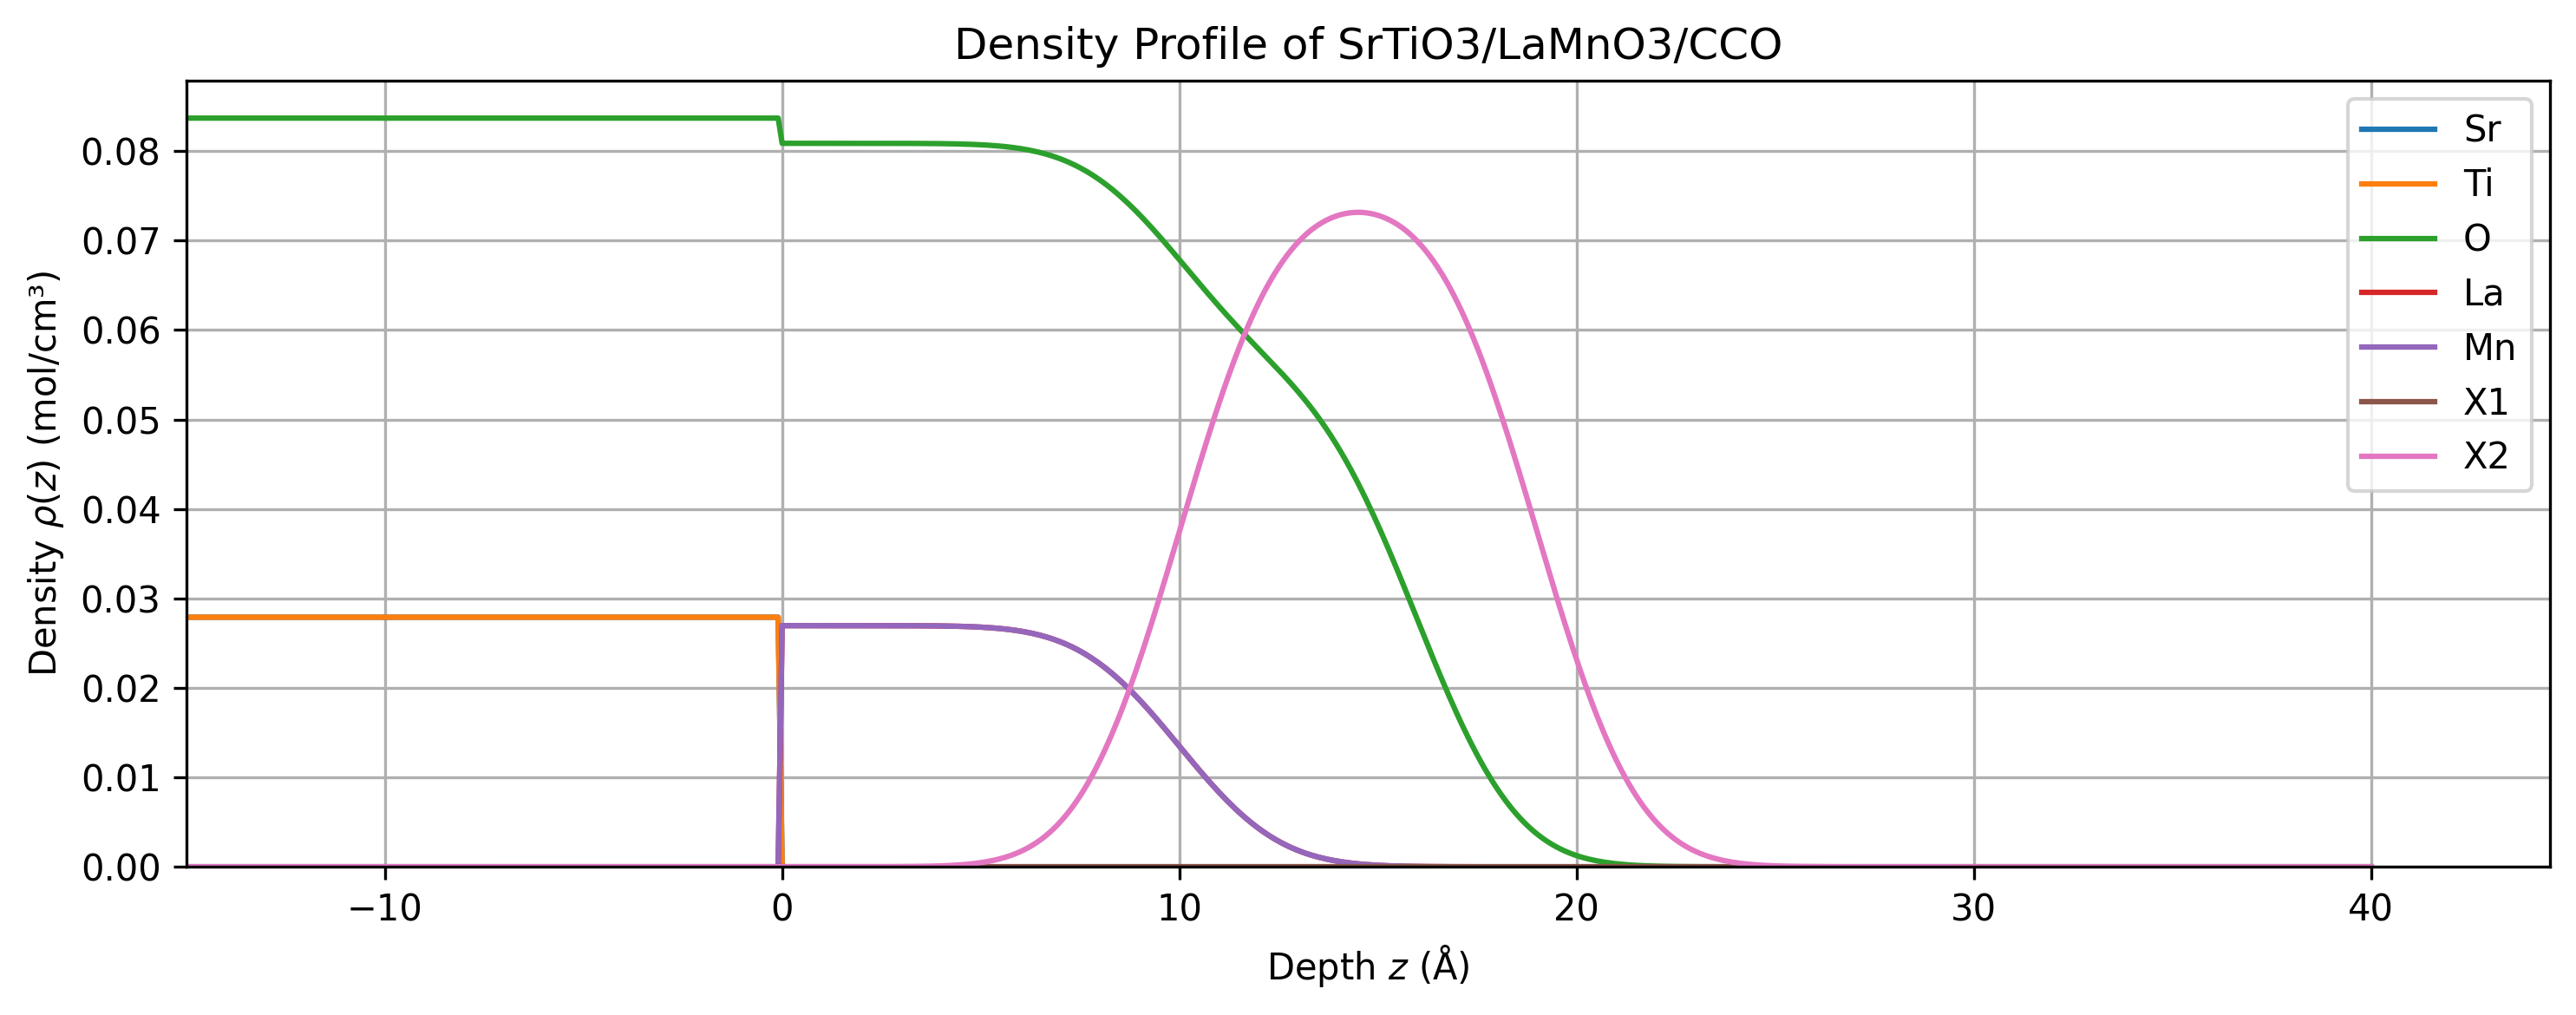

In [10]:
z, dens, m_dens, _ = get_density_profile_from_element_data(
    struc.element_data, struc.atoms, struc.step
)
plot_density_profile(
    z, dens, title="Density Profile of SrTiO3/LaMnO3/CCO", x_move=-50.0, min_x=-15.0
)

Number of segments: 193
Tiempo de ejecución: 0.062 segundos


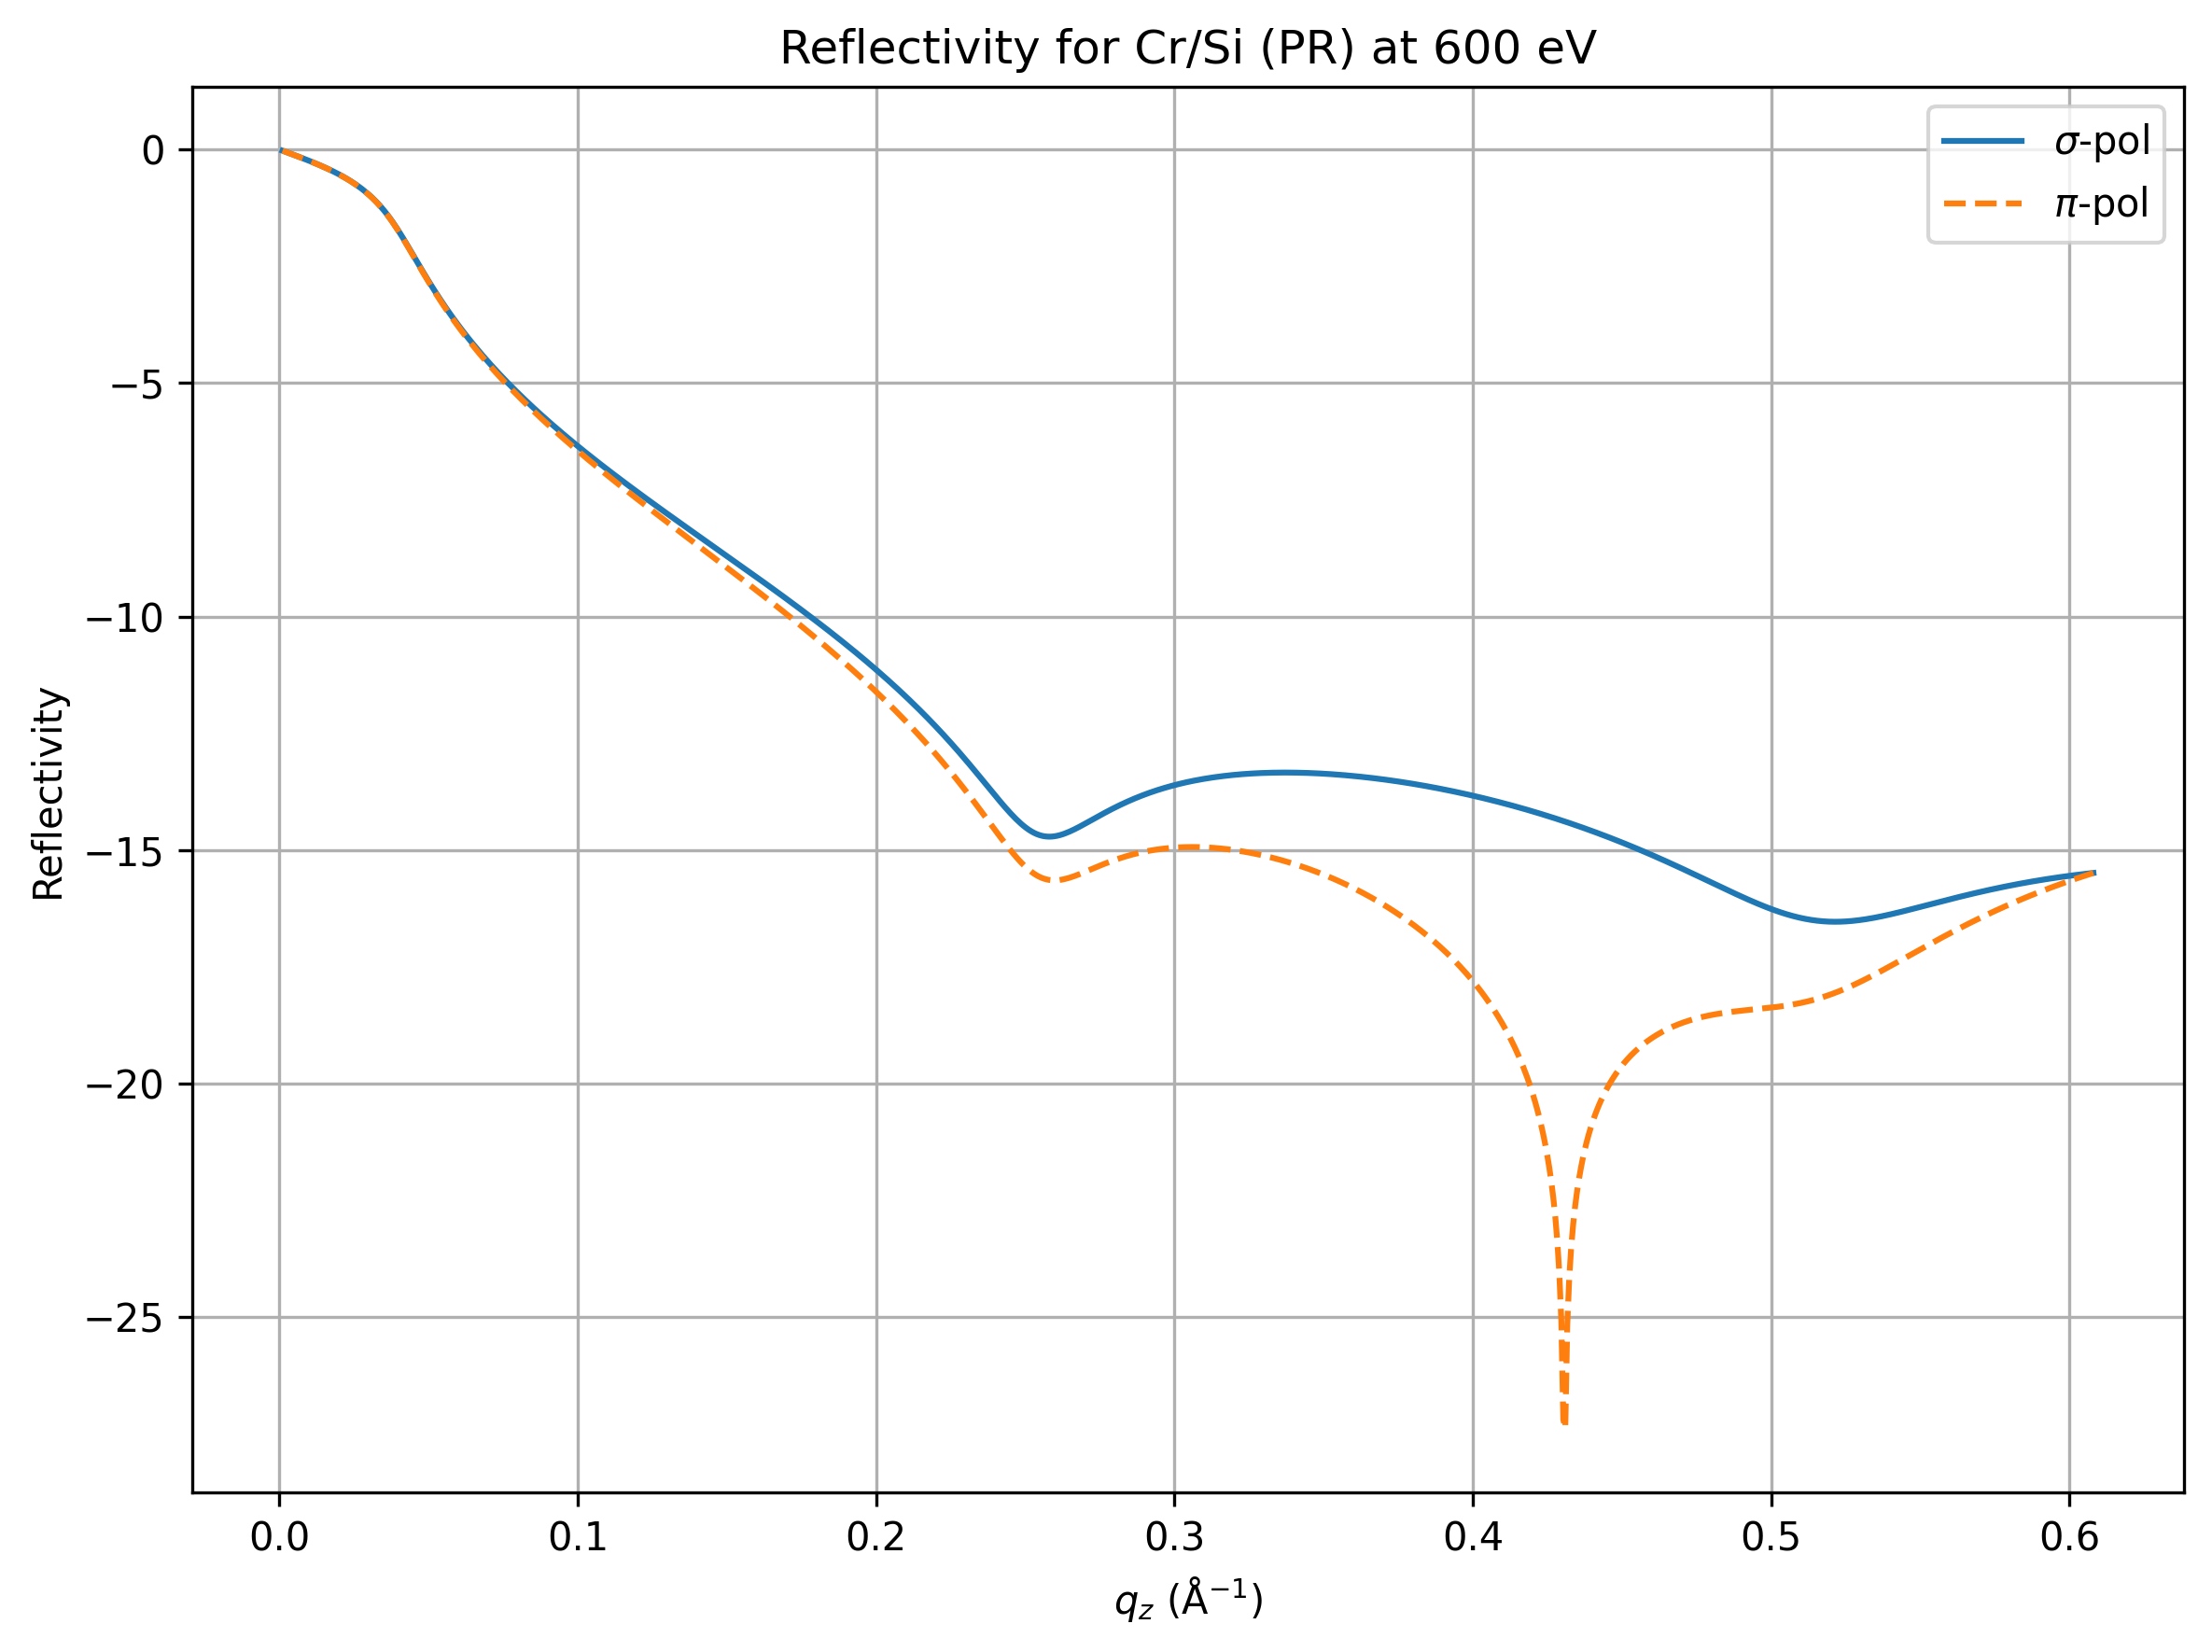

In [12]:
backend = PRReflectivityBackend()
model.set_reflectivity_backend(backend)

start_time = time.time()
E_eV = 600
Theta = np.linspace(0.1, 89.1, num=1001)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)
res = model.compute_reflectivity(qz, E_eV)
end_time = time.time()

print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")
plot_reflectivity(qz, res.R_s, res.R_p, E_eV, "Cr/Si (PR)")

Tiempo de ejecución: 0.337 segundos


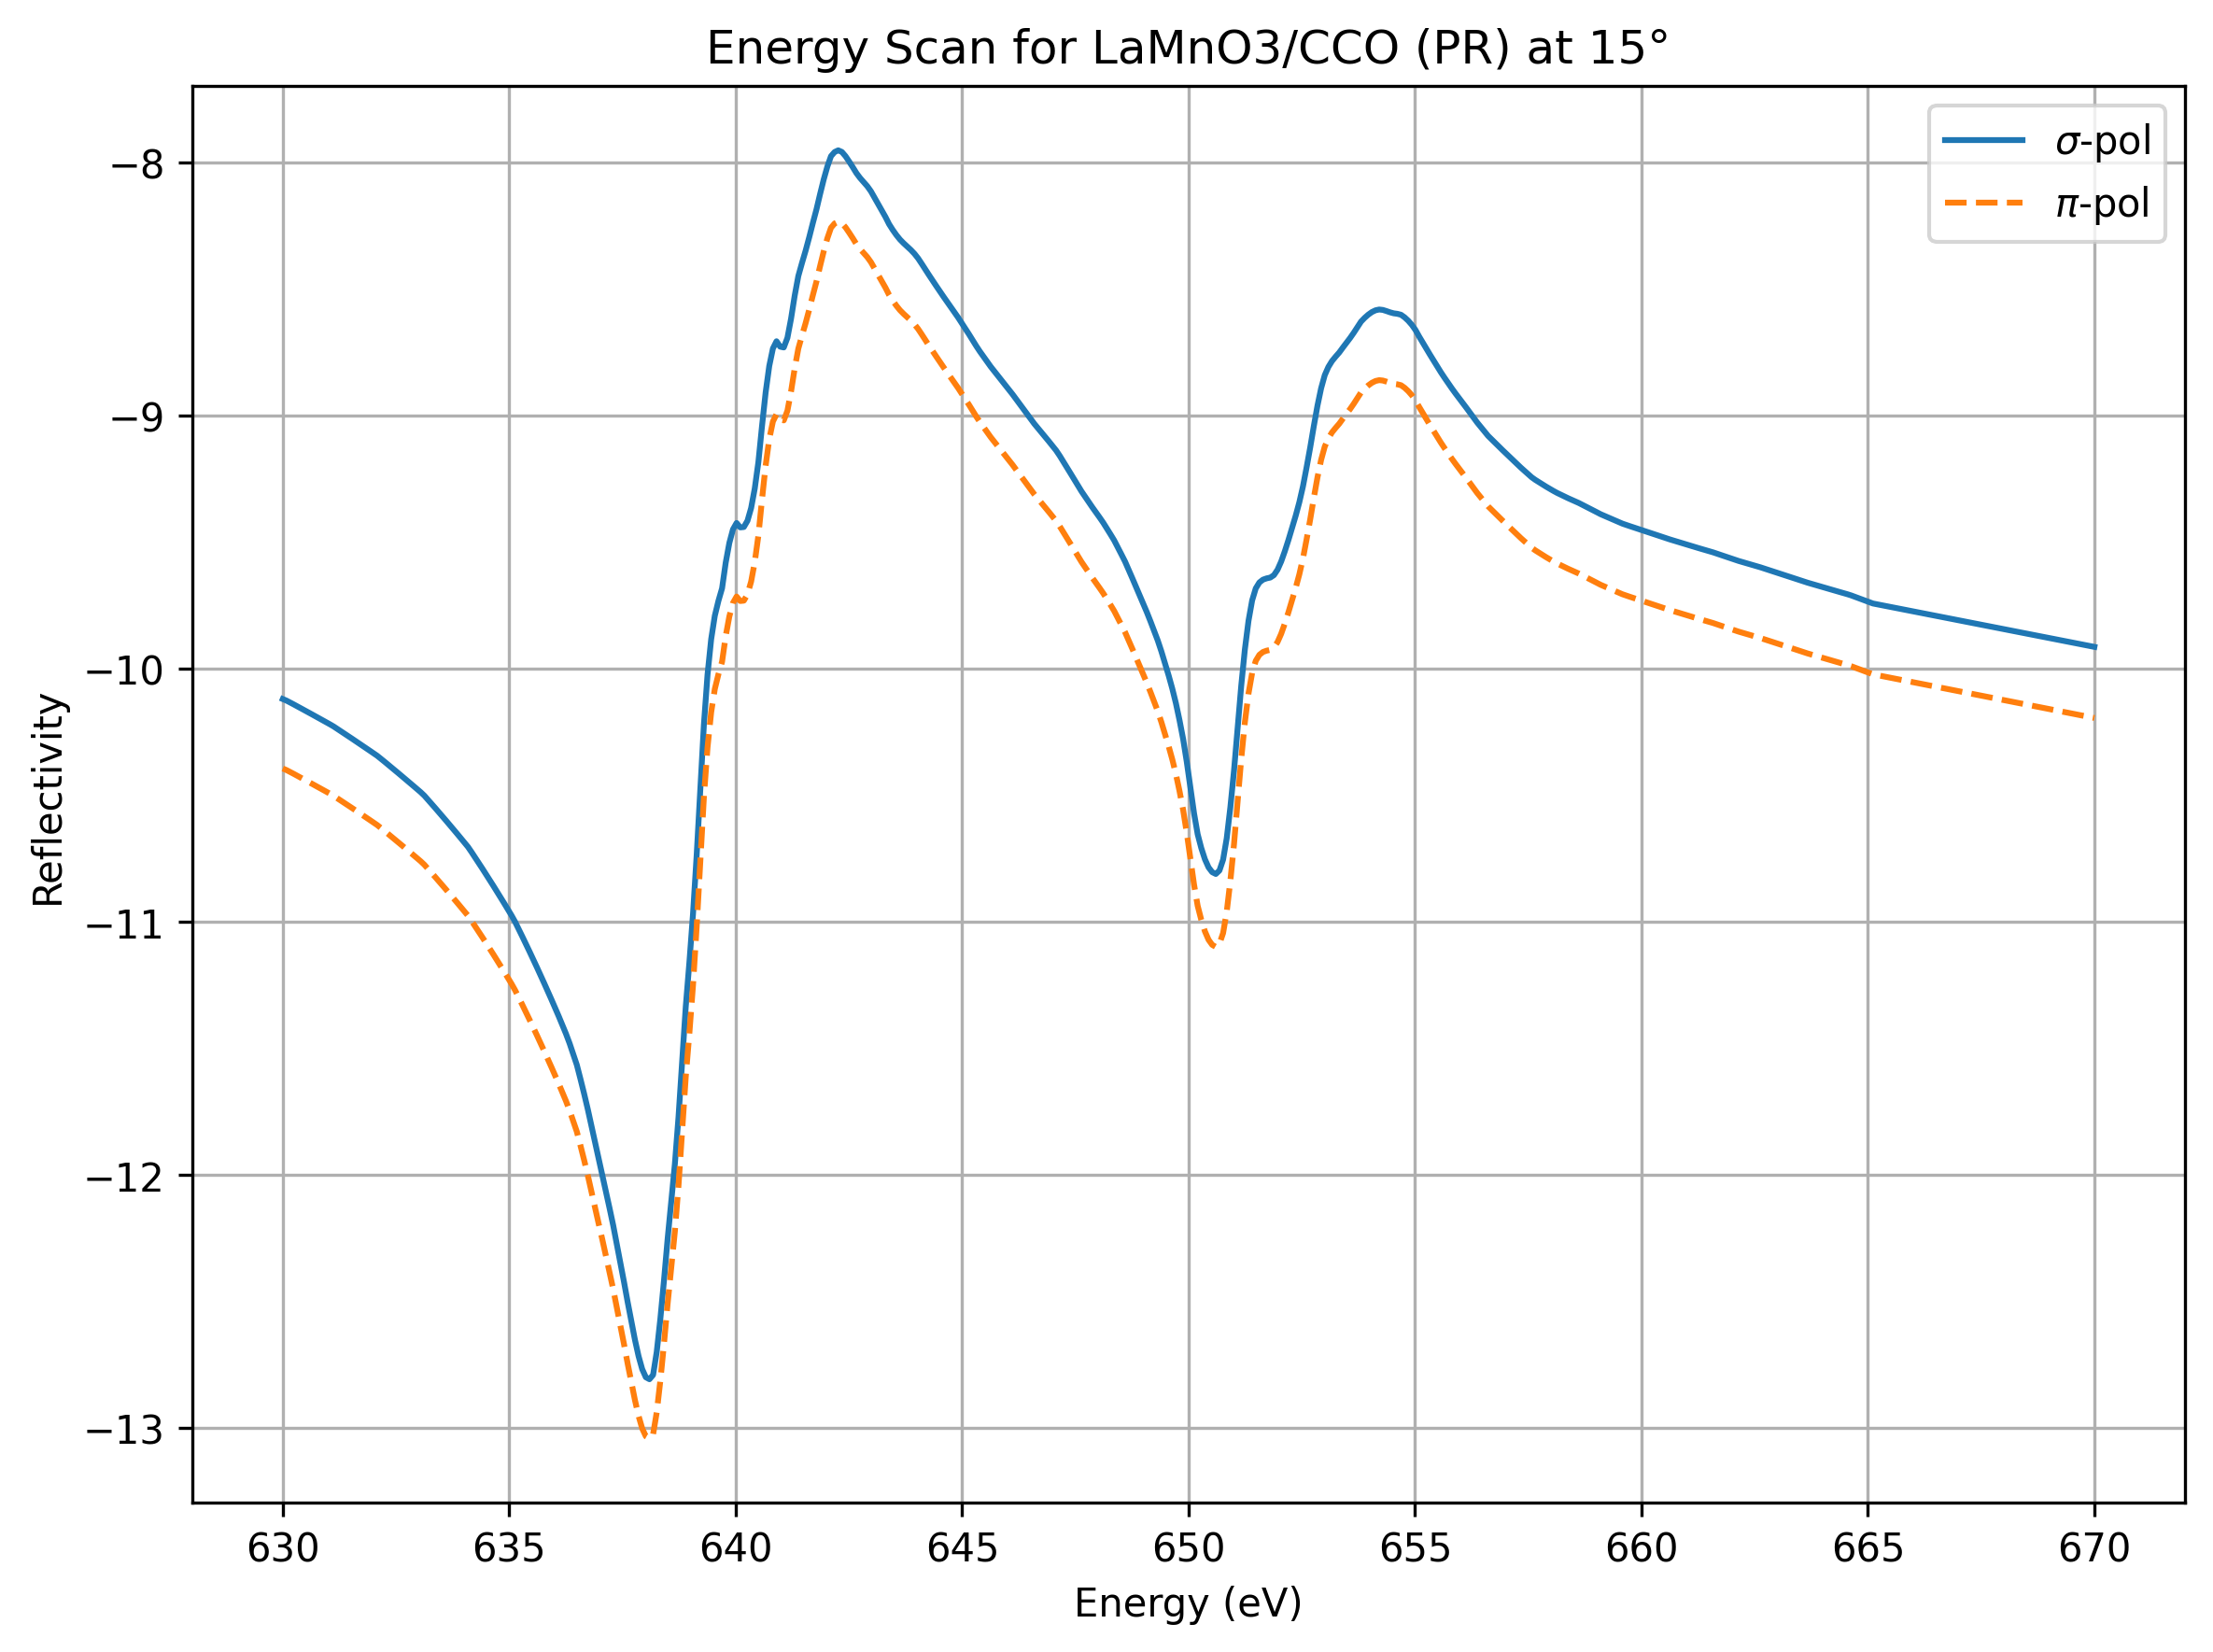

In [16]:
start_time = time.time()

theta_deg = 15
e_evs = np.linspace(630, 670, num=500).tolist()
res_energy = model.compute_energy_scan(e_evs, theta_deg)
end_time = time.time()

print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")
plot_energy_scan(res_energy.energy_range, res_energy.R_s, res_energy.R_p, theta_deg, "LaMnO3/CCO (PR)")

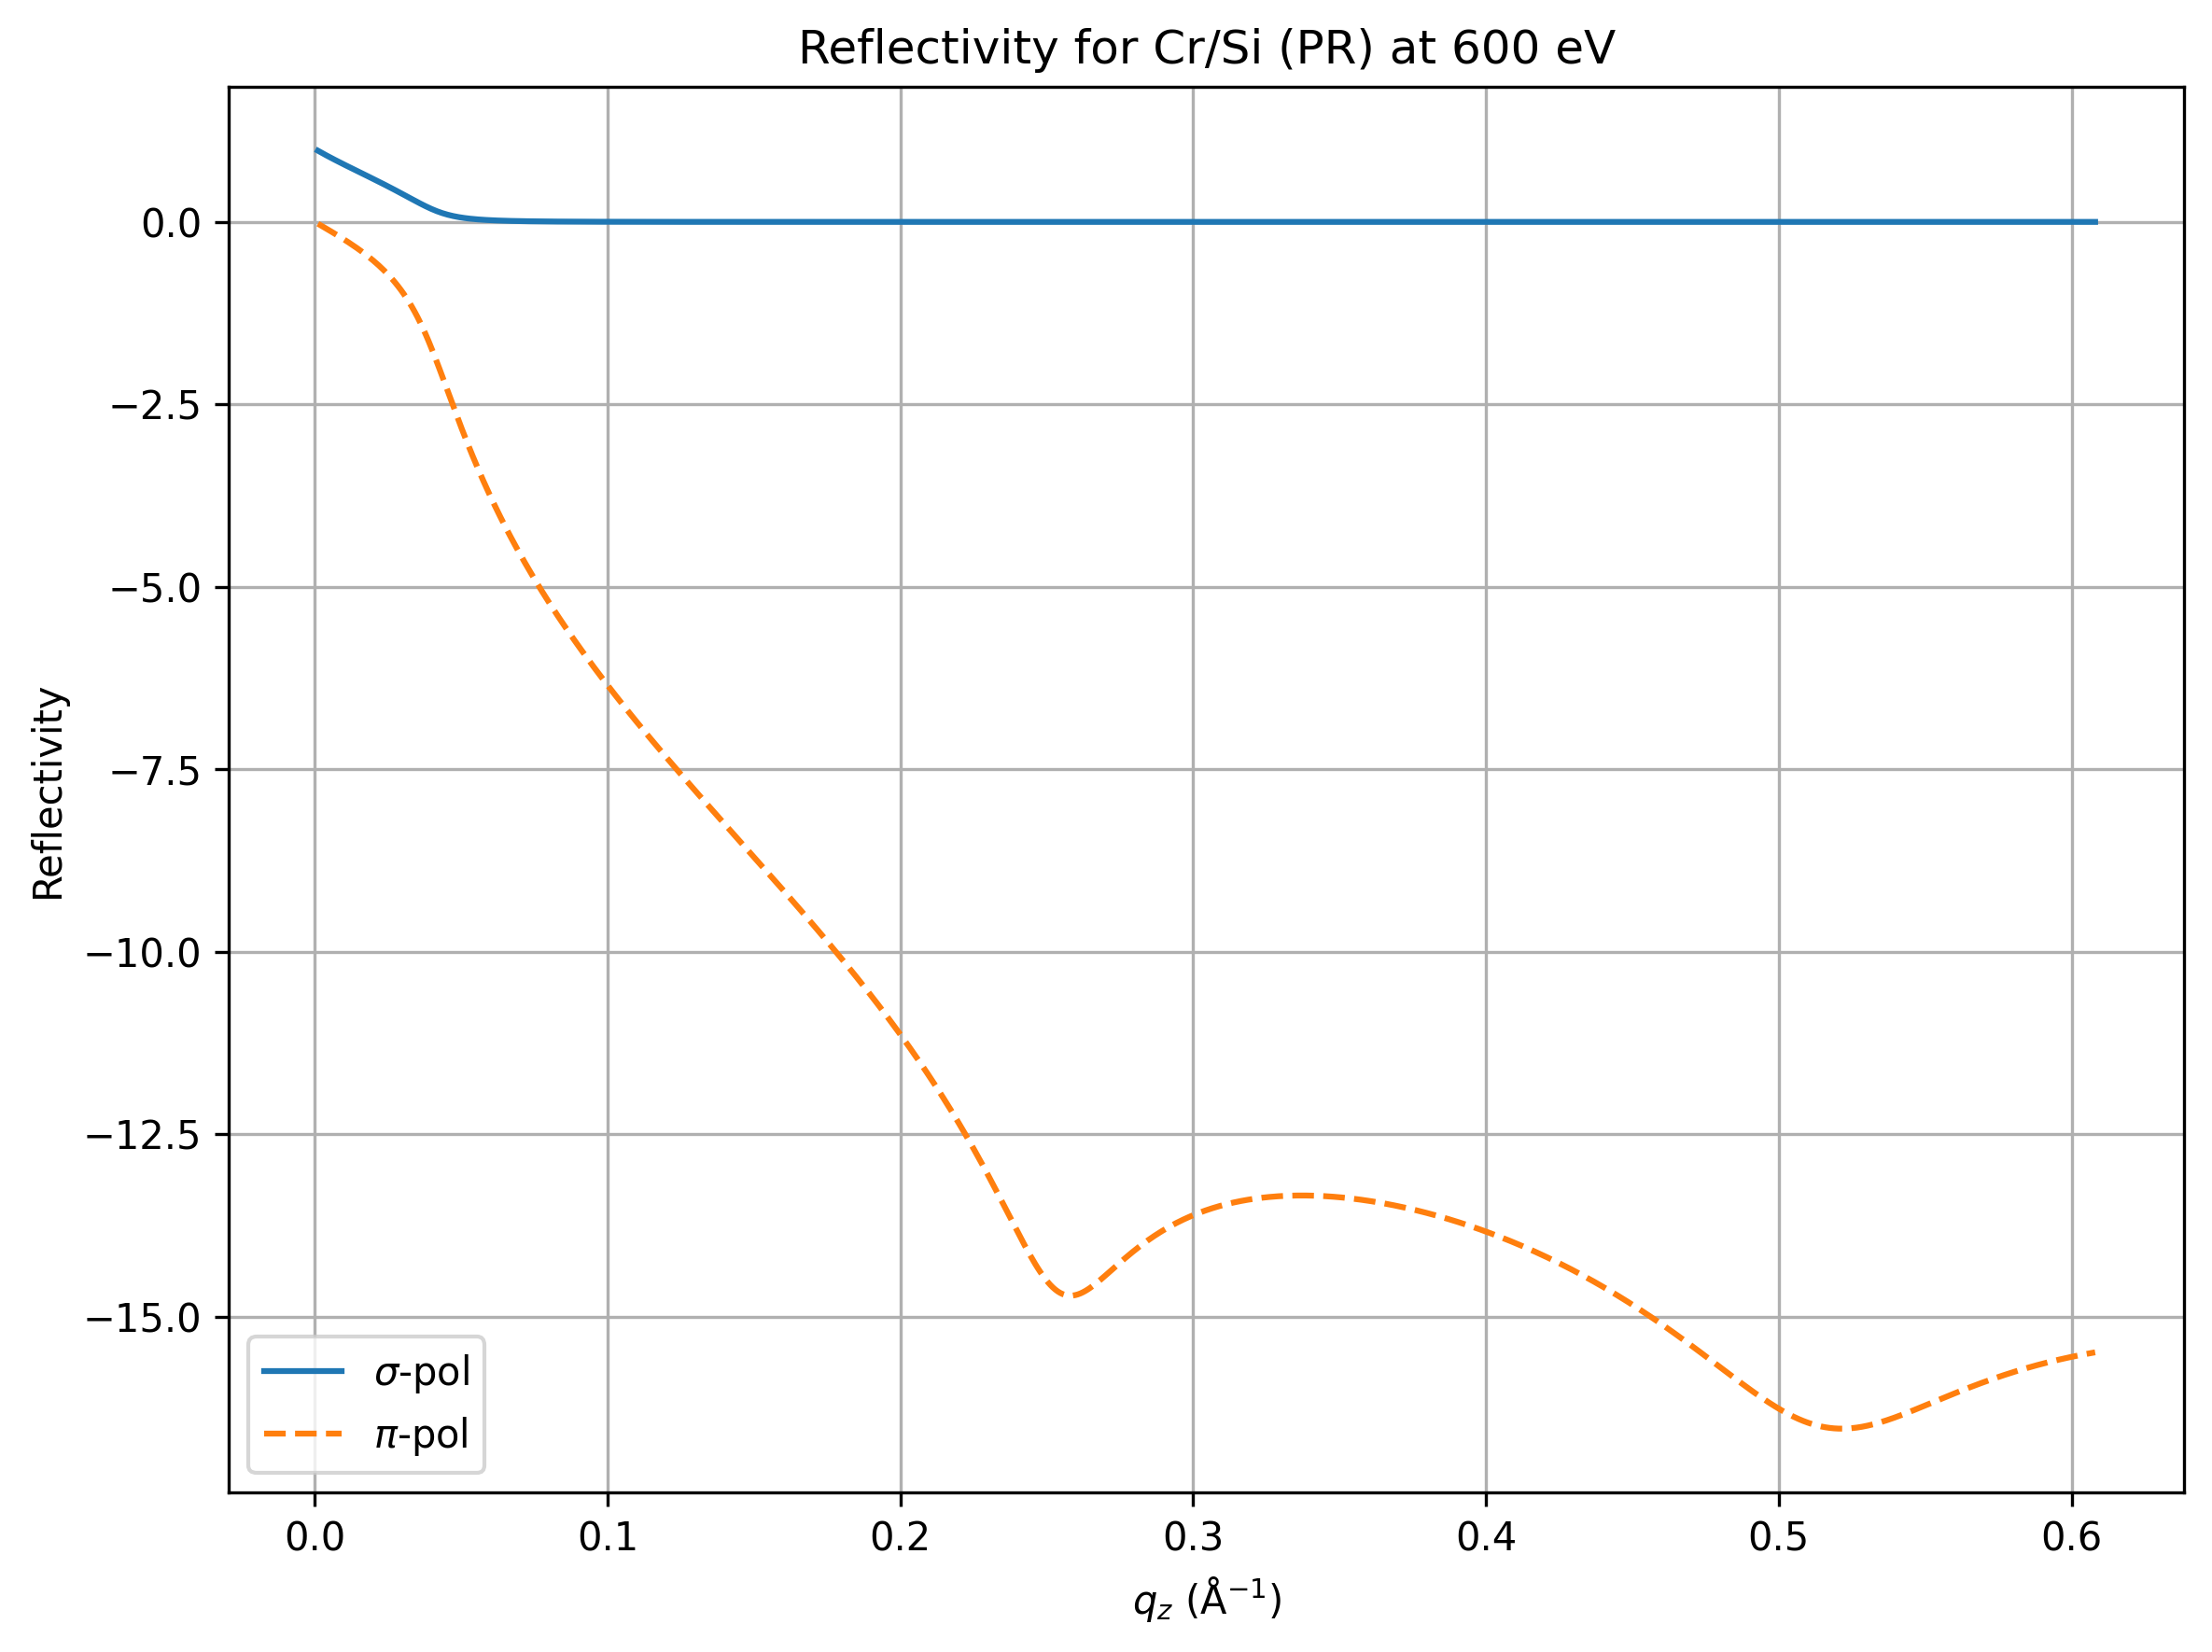

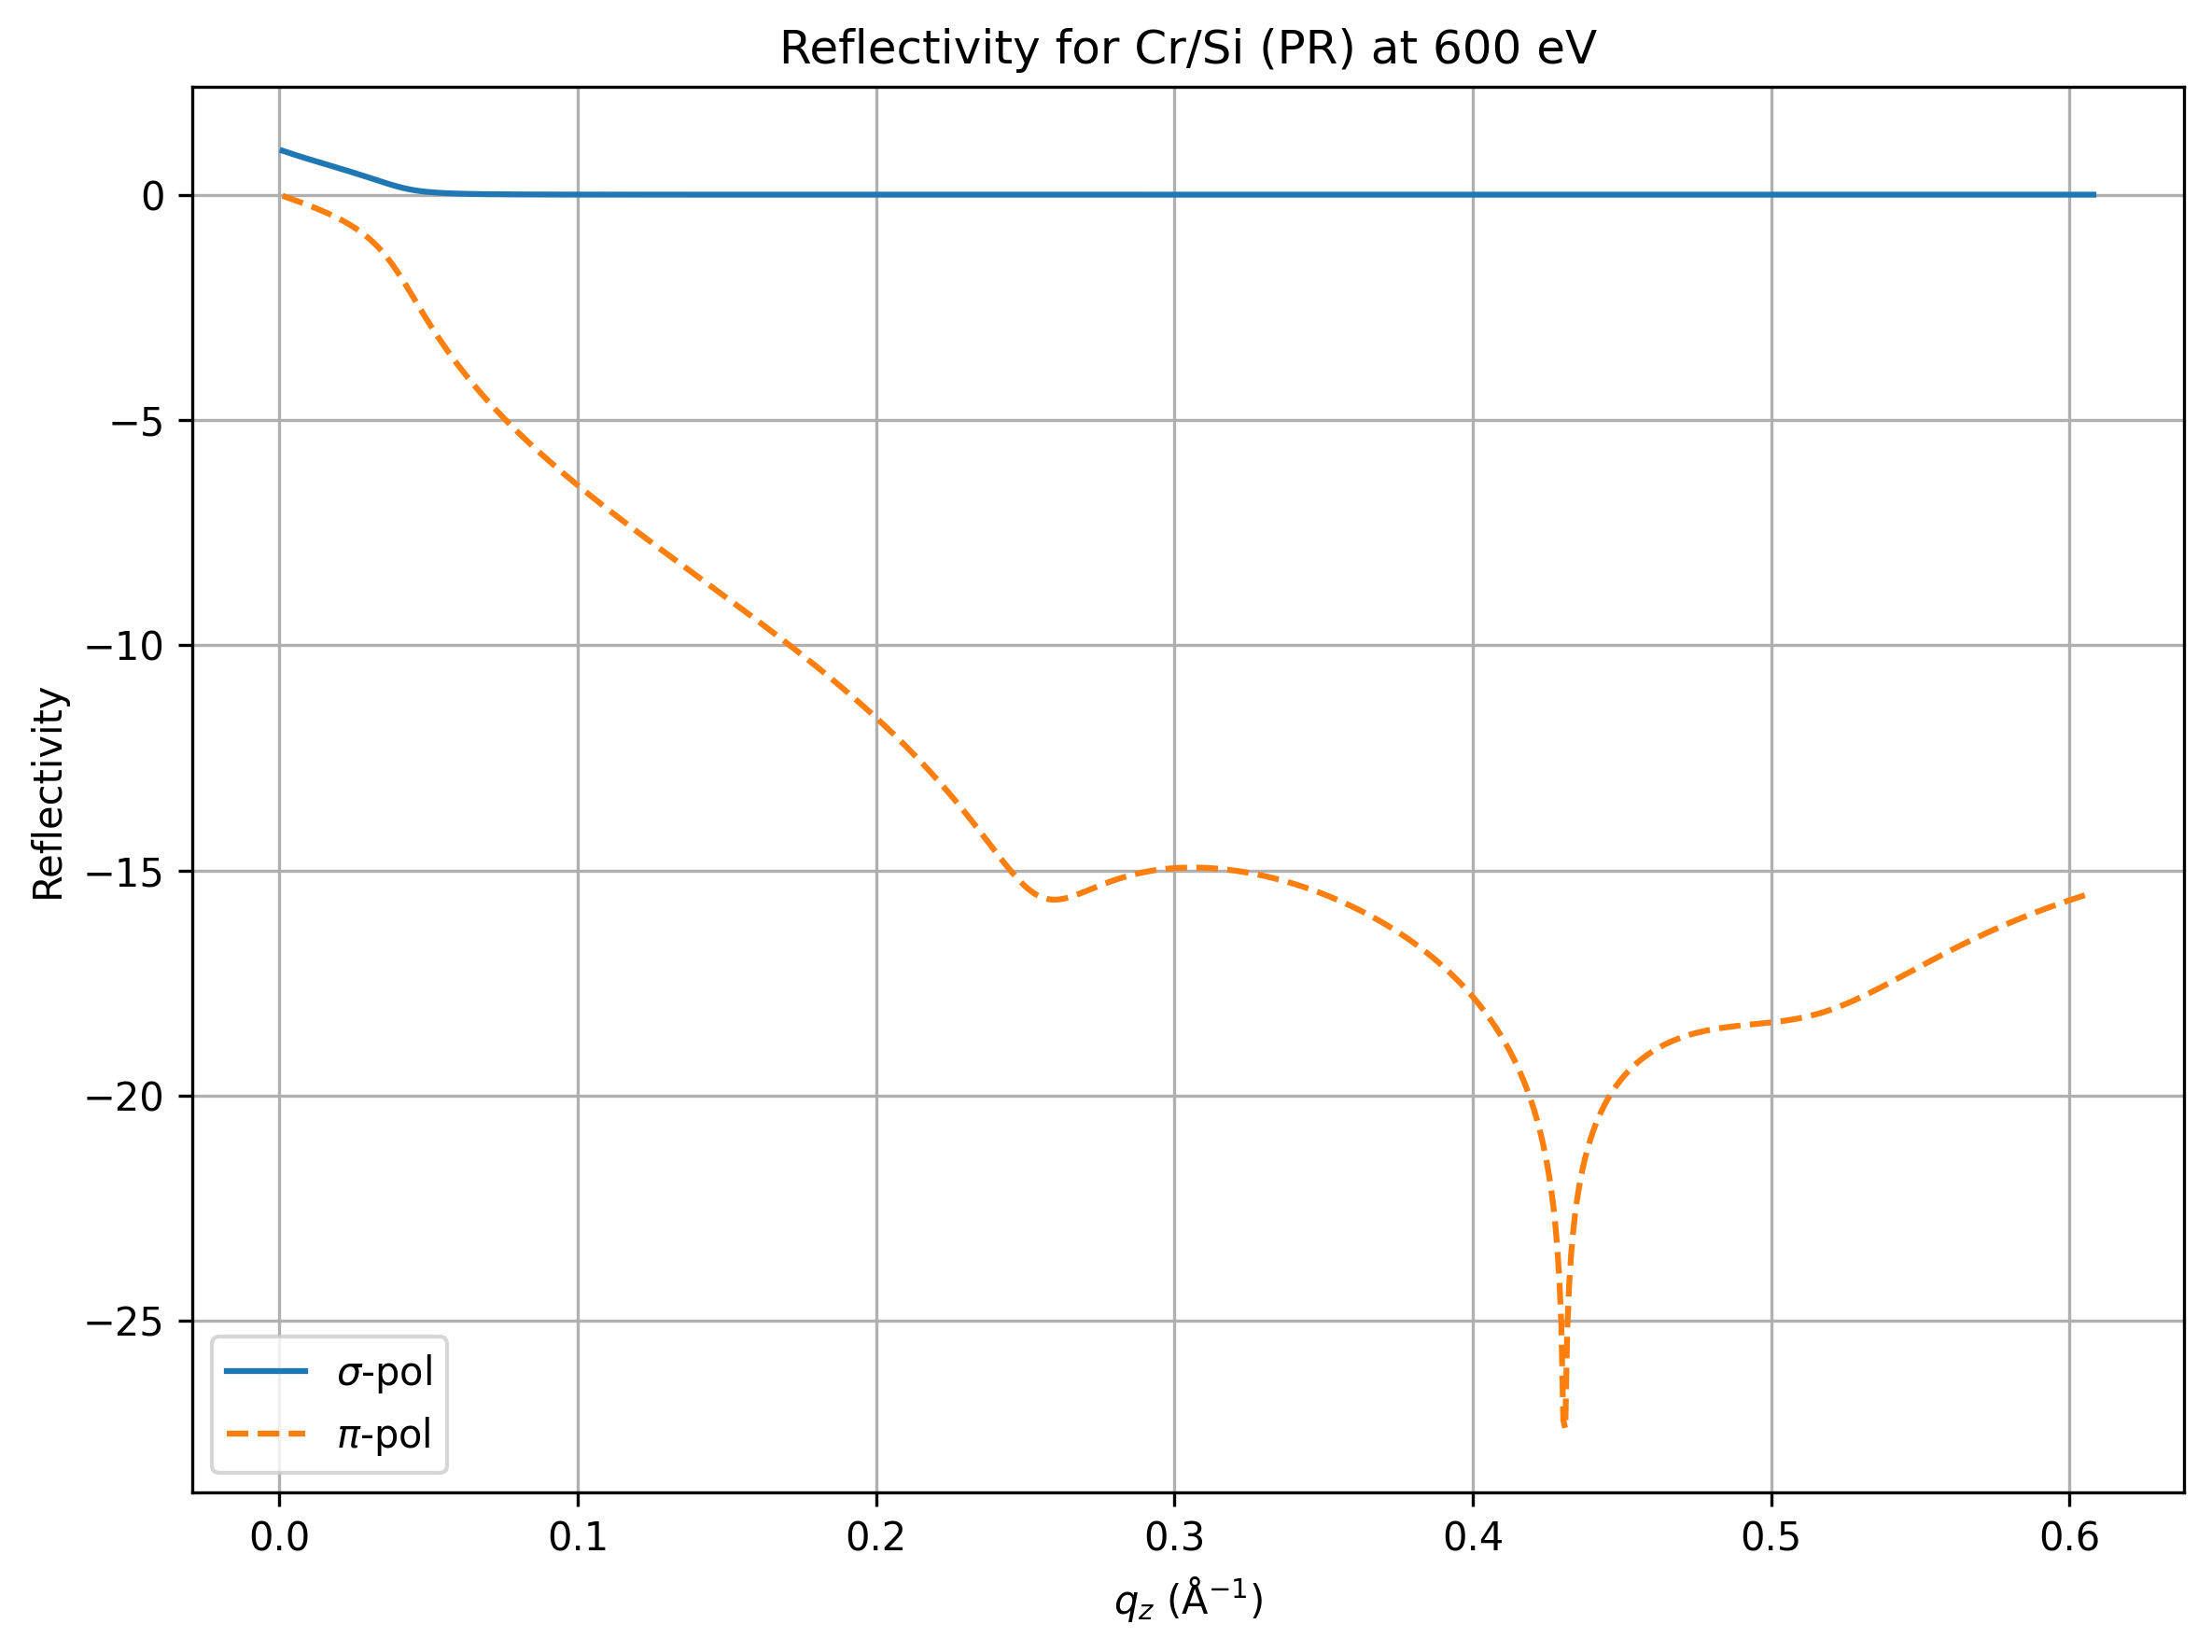

In [17]:
file_path = "/Users/niaggar/Developer/mitacs/reflectivity_test_data.txt"
data = np.loadtxt(file_path)
qz, R_Sgo, R_Pgo = data.T

plot_reflectivity(qz, R_Sgo, res.R_s, E_eV, "Cr/Si (PR)")
plot_reflectivity(qz, R_Pgo, res.R_p, E_eV, "Cr/Si (PR)")